Problem 2: Regresija [20p] U arhivi se nalazi skup podataka bottle.csv koji sadrži podatke o raznim ispitivanjima vode iz okeana. Nas zanima veza saliniteta i temperature vode. Više informacija o skupu podataka možete naći ovde. Cilj je predvideti temperaturu vode u odnosu na salinitet

a. [10p] U fajlu 2a.py na ovom skupu podataka primeniti polinomijalnu regresiju, uz variranje stepena polinoma u intervalu [1, 6]. Pokretanje programa treba da proizvede dva grafika: jedan na kome su u 2D prikazani svi podaci iz skupa kao i svih 6 regresionih krivih, i drugi na kome je prikazana zavisnost finalne funkcije troška na celom skupu (ne u poslednjoj epohi treninga!) od stepena polinoma. Šta možemo primetiti? Diskutovati u komentaru ispod koda.

b. [10p] U fajlu 2b.py trenirati polinomijalnu regresiju sa fiksnim stepenom polinoma 4, ali uz dodatu L2 regularizaciju. Za parametar lambda probati vrednosti iz skupa {0, 0.001, 0.01, 0.1, 1, 10, 100}. U redu je krenuti od kompletne kopije prethodnog fajla. Pokretanje programa treba da kreira dva grafika slična onima u prethodnom delu problema: grafik svih podataka sa 7 regresionih krivih (za različite vrednosti lambda) i grafik zavisnosti finalne funkcije troška na celom skupu od parametra lambda. Šta sada možemo primetiti? Diskutovati u komentaru ispod koda. Trazimo T_degC,Salnty

Lambda value: 0
loss from final epoch 0.12219701707363129
w = [-1.1825068  -0.07807547  0.11868231 -0.03938254], bias = 0.3096802234649658
Lambda value: 0.001
loss from final epoch 0.12256789952516556
w = [-1.1804308  -0.07639215  0.11720484 -0.04013757], bias = 0.3090439736843109
Lambda value: 0.01
loss from final epoch 0.12583769857883453
w = [-1.1622772  -0.06236285  0.10434254 -0.04644855], bias = 0.3037361800670624
Lambda value: 0.1
loss from final epoch 0.15332014858722687
w = [-1.0189699   0.01165302  0.00651078 -0.08087525], bias = 0.2752585709095001
Lambda value: 1
loss from final epoch 0.27759188413619995
w = [-0.560902    0.03411796 -0.2461006  -0.09563326], bias = 0.2472822219133377
Lambda value: 10
loss from final epoch 0.5944221019744873
w = [-0.19492523  0.02160816 -0.19047469 -0.01958237], bias = 0.11756870895624161
Lambda value: 100
loss from final epoch 0.9253061413764954
w = [-0.02372206  0.01208047 -0.02143043  0.00442884], bias = 0.0277568306773901


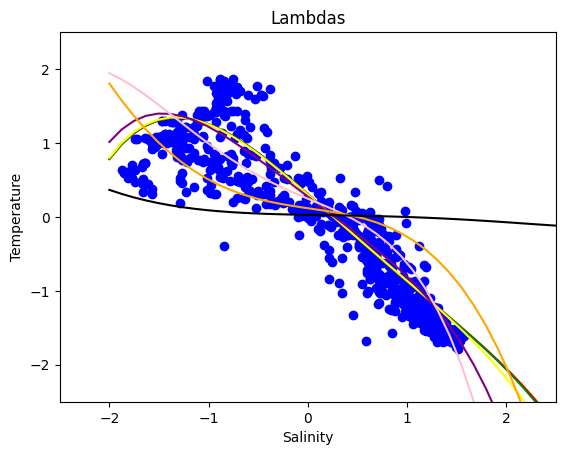

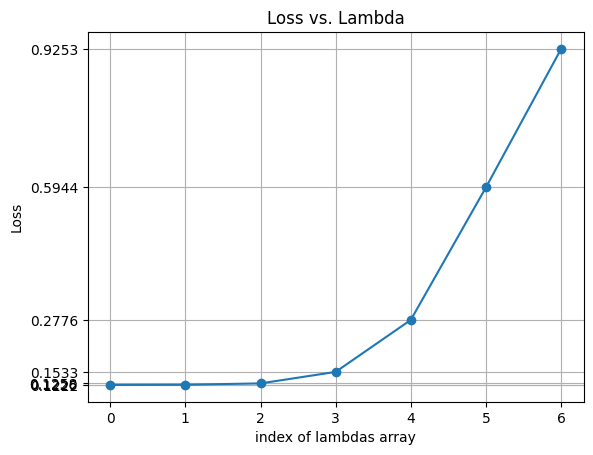

In [ ]:
import matplotlib.pyplot as plot
import pandas as pd
import numpy as np
import tensorflow as tf

filename = "bottle.csv"
colors = ["red", "green", "yellow", "purple", "pink", "orange","black"]
lambdas = [0, 0.001, 0.01, 0.1, 1, 10, 100]
all_data = np.genfromtxt(filename, delimiter=',', skip_header=1, usecols=(5, 6), dtype='float32')

valid_rows_mask = ~np.isnan(all_data).any(axis=1)
filtered_data = all_data[valid_rows_mask]

if len(filtered_data) > 700:
    filtered_data = filtered_data[:700]
elif len(filtered_data) < 700:
    remaining_rows = 700 - len(filtered_data)
    additional_data = np.genfromtxt(filename, delimiter=',', skip_header=len(all_data) - remaining_rows,
                                    usecols=(5, 6), dtype='float32')
    filtered_data = np.concatenate((filtered_data, additional_data), axis=0)

sample_data = filtered_data[:30]

data = dict()
data["x"] = filtered_data[:, 1]
data["y"] = filtered_data[:, 0]

data['x'] = (data['x'] - np.mean(data['x'], axis=0)) / np.std(data['x'], axis=0)
data['y'] = (data['y'] - np.mean(data['y'])) / np.std(data['y'])

def create_feature_matrix(x, nb_features):
    tmp_features = []
    for deg in range(1, nb_features + 1):
        tmp_features.append(np.power(x, deg))
    return np.column_stack(tmp_features)

nb_samples = data['x'].shape[0]

learning_rate = 0.001
number_of_epochs = 100

def predict(x, w, b):
    w_col = tf.reshape(w, (nb_features, 1))
    hypothesis = tf.add(tf.matmul(x, w_col), b)
    return hypothesis

def train_step(x, y, weight, bias,lambda_value):
    w_grad, b_grad, loss_val = calc_grad(x, y, weight, bias,lambda_value)
    adam.apply_gradients(zip([w_grad, b_grad], [weight, bias]))
    return loss_val


def loss(x, y, weight, bias,lambda_value):
    prediction = predict(x, weight, bias)
    y_column = tf.reshape(y, (-1, 1))
    mse = tf.reduce_mean(tf.square(prediction - y_column))

    #dodata regularizacija
    l2_reg = lambda_value * tf.reduce_mean(tf.square(weight))
    loss = tf.add(mse, l2_reg)

    return loss

def calc_grad(x, y, weight, bias,lambda_value):
    with tf.GradientTape() as tape:
        loss_val = loss(x, y, weight, bias,lambda_value)
    w_grad, b_grad = tape.gradient(loss_val, [weight, bias])
    return w_grad, b_grad, loss_val

losses = []
#fiksiramo na polinom 4 stepena
nb_features = 4

for lbd in range(1, 8):
    print(f"Lambda value: {lambdas[lbd-1]}")
    data['x_poly'] = create_feature_matrix(data['x'], nb_features)

    weight = tf.Variable(tf.zeros(nb_features))
    bias = tf.Variable(0.0)

    adam = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    for epoch in range(number_of_epochs):
        epoch_loss = 0
        for sample in range(nb_samples):
            x = data["x_poly"][sample].reshape((1, nb_features))
            y = data["y"][sample]

            curr_loss = train_step(x, y, weight, bias,lambdas[lbd-1])
            epoch_loss += curr_loss
        epoch_loss /= nb_samples

    losses.append(epoch_loss.numpy())
    print(f"loss from final epoch {epoch_loss}")
    print(f'w = {weight.numpy()}, bias = {bias.numpy()}')

    xs = create_feature_matrix(np.linspace(-2, 4, 50, dtype='float32'), nb_features)
    hyp_val = predict(xs, weight, bias)
    plot.plot(xs[:, 0].tolist(), hyp_val.numpy().tolist(), color=colors[lbd-1])

plot.scatter(data['x'], data['y'], color='blue', label='Data Points')
plot.xlabel('Salinity')
plot.ylabel('Temperature')
plot.title(f'Lambdas')
plot.xlim([-2.5, 2.5])
plot.ylim([-2.5, 2.5])
plot.show()


plot.figure()
degrees = range(0, 7)
plot.plot(degrees, losses, marker='o')
plot.xlabel('index of lambdas array')
plot.ylabel('Loss')
plot.title('Loss vs. Lambda')
plot.xticks(degrees)
plot.yticks(losses)
plot.grid(True)
plot.show()

Gledajuci gornja dva grafika dolazimo do iducih saznanja:
Odokativno receno sto se lambda vrijednost povecava to ce sam grafik i loss vrijednost rasti.
Sama normalizacija je pozitivno djelovala na primjetan overfitting time sto je razlika izmedju manjih i vecih vrijednosti jako uocljiva, ali sa ekstremno
velikim vrijednostima pocinje detrimentalno da djeluje na rezultat samim time sto poslednja vrijednost od 100 je polinomijalnu pravu maltene okrenula za 60 stepeni. Isto tako ako gledamo drugi grafik mozemo zakljuciti da nakon 3-eg indeksa stopa greske se povecava, to nam govori da vrijednosti za l2 regularizaciju pomocu lamba vrijednosti : 1 , 10 i 100 nisu adekvatne jer u cilju smanjenja overfitting dovode do hajde da kazemo "underfitting"-a